Using device: cuda
Input Size: 14
Epoch 1/200, Train Loss: 0.6488, Precision: 0.6317, Recall: 0.5533, F1 Score: 0.5899, Accuracy: 0.6153, Validation Loss: 0.5863
Epoch 2/200, Train Loss: 0.5644, Precision: 0.8013, Recall: 0.4734, F1 Score: 0.5952, Accuracy: 0.6780, Validation Loss: 0.5228
Epoch 3/200, Train Loss: 0.5237, Precision: 0.8489, Recall: 0.4906, F1 Score: 0.6218, Accuracy: 0.7016, Validation Loss: 0.4789
Epoch 4/200, Train Loss: 0.4876, Precision: 0.8250, Recall: 0.6008, F1 Score: 0.6953, Accuracy: 0.7367, Validation Loss: 0.4323
Epoch 5/200, Train Loss: 0.4473, Precision: 0.8189, Recall: 0.7133, F1 Score: 0.7625, Accuracy: 0.7778, Validation Loss: 0.3784
Epoch 6/200, Train Loss: 0.4058, Precision: 0.8314, Recall: 0.8109, F1 Score: 0.8211, Accuracy: 0.8232, Validation Loss: 0.3422
Epoch 7/200, Train Loss: 0.3820, Precision: 0.8327, Recall: 0.8603, F1 Score: 0.8462, Accuracy: 0.8437, Validation Loss: 0.3207
Epoch 8/200, Train Loss: 0.3584, Precision: 0.8519, Recall: 0.8734, F1

C:\Users\ojasv\AppData\Local\Temp\ipykernel_13908\2585033235.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('drug_interaction_model_b

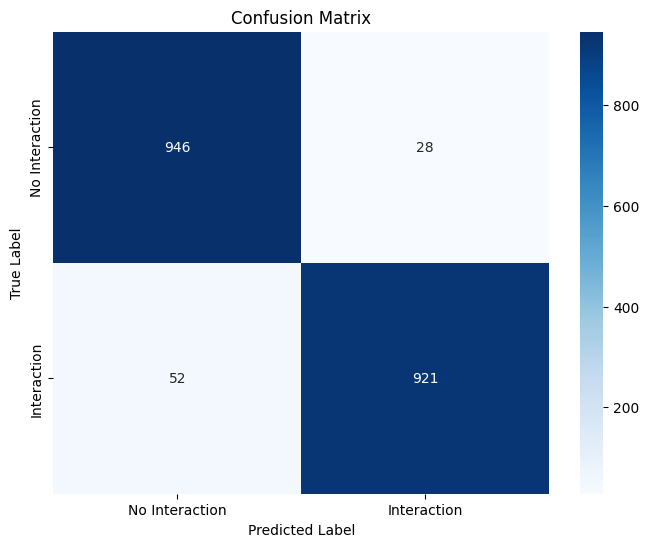

ROC-AUC Score: 0.9857


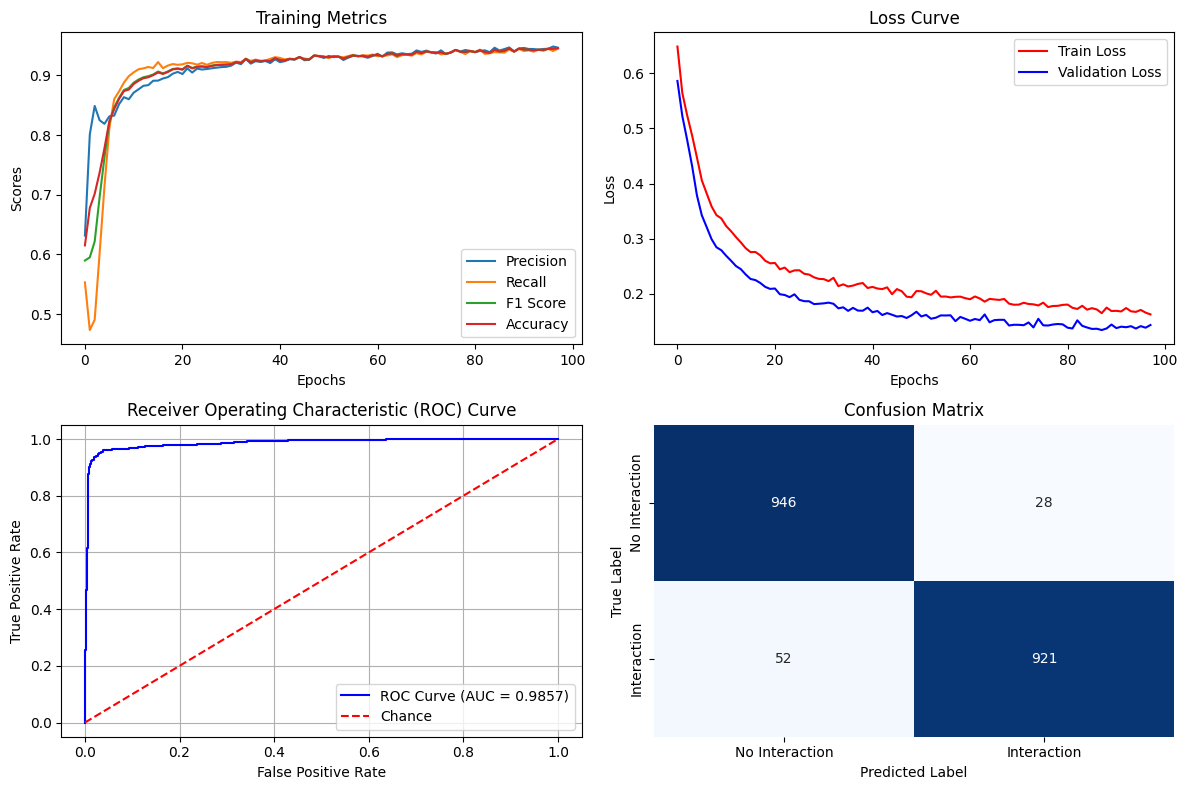

In [5]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns


train_data = pd.read_csv('data/train_dataset(onehot).csv')
test_data = pd.read_csv('data/test_dataset(onehot).csv')


X_train = train_data.drop('Interaction', axis=1).values
y_train = train_data['Interaction'].values
X_test = test_data.drop('Interaction', axis=1).values
y_test = test_data['Interaction'].values


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class DrugInteractionModel(nn.Module):
    def __init__(self, input_size):
        super(DrugInteractionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

input_size = X_train.shape[1]
print("Input Size:", input_size)
model = DrugInteractionModel(input_size).to(device)


criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


epochs = 200
train_losses = []
val_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())


    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(total_loss / len(train_loader))
    train_precisions.append(precision)
    train_recalls.append(recall)
    train_f1_scores.append(f1)
    train_accuracies.append(accuracy)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}, "
          f"Validation Loss: {val_losses[-1]:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'drug_interaction_model_best.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(torch.load('drug_interaction_model_best.pth'))
model.eval()
y_pred_probs = []
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        probabilities = outputs.cpu().numpy()
        predictions = (outputs > 0.5).float()
        y_pred_probs.extend(probabilities)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())


print("Classification Report:\n", classification_report(y_true, y_pred, digits=4))


conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Interaction", "Interaction"], yticklabels=["No Interaction", "Interaction"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


plt.figure(figsize=(12, 8))
epochs_trained = len(train_losses)


plt.subplot(2, 2, 1)
plt.plot(range(epochs_trained), train_precisions, label='Precision')
plt.plot(range(epochs_trained), train_recalls, label='Recall')
plt.plot(range(epochs_trained), train_f1_scores, label='F1 Score')
plt.plot(range(epochs_trained), train_accuracies, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.legend()
plt.title('Training Metrics')


plt.subplot(2, 2, 2)
plt.plot(range(epochs_trained), train_losses, label='Train Loss', color='r')
plt.plot(range(epochs_trained), val_losses, label='Validation Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')


roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")


fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='b')
plt.plot([0, 1], [0, 1], 'r--', label='Chance')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()


plt.subplot(2, 2, 4)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No Interaction", "Interaction"], yticklabels=["No Interaction", "Interaction"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()


plt.show()


Prediction Code

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class DrugInteractionModel(nn.Module):
    def __init__(self, input_size):
        super(DrugInteractionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device:",device)

model = DrugInteractionModel(input_size=14).to(device) 
model.load_state_dict(torch.load('drug_interaction_model_best.pth'))
model.eval()  


def encode_cyp3a4(cyp_value):
    
    encoding = np.zeros(4)
    encoding[int(cyp_value)] = 1
    return encoding


def predict_interaction(drug1_cyp3a4, drug1_binding_affinity, drug1_renal_clearance, drug1_logP, 
                        drug2_cyp3a4, drug2_binding_affinity, drug2_renal_clearance, drug2_logP):
    
    drug1_cyp = encode_cyp3a4(drug1_cyp3a4)
    drug2_cyp = encode_cyp3a4(drug2_cyp3a4)
    
    
    input_features = np.array([[drug1_binding_affinity, drug1_renal_clearance, drug1_logP,
                                drug2_binding_affinity, drug2_renal_clearance, drug2_logP] + drug1_cyp.tolist() + drug2_cyp.tolist()])
    
    
    input_tensor = torch.tensor(input_features, dtype=torch.float32).to(device)
    
    
    with torch.no_grad():
        prediction = model(input_tensor).item()  
        interaction = int(prediction > 0.5)  
        return interaction, prediction  

#interaction, probability = predict_interaction(0,0.566,0.964,0.277,3,0.283,0.542,0.682)

interaction, probability = predict_interaction(3,0.91,0.090,0.44,1,0.83,0.10,0.26)


print(f"Predicted Interaction: {interaction} (0: No Interaction, 1: Interaction)")
print(f"Probability of Interaction: {probability:.4f}")


Using Device: cuda
Predicted Interaction: 1 (0: No Interaction, 1: Interaction)
Probability of Interaction: 0.9746


C:\Users\ojasv\AppData\Local\Temp\ipykernel_13908\1586548338.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('drug_interaction_model_be

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Assuming you have already defined your model and data (X_test, y_test)

# Define the model (you can also reuse the already defined 'm' model if available)
m = SVC(kernel='rbf', random_state=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10]
}

# Set up GridSearchCV to optimize for recall
grid_search = GridSearchCV(estimator=m, param_grid=param_grid, scoring='recall', cv=5)

# Fit the model to the training data (X_train, y_train) - assuming you have training data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

# Use the best model to predict on the test set
y_pred = best_model.predict(X_test)

# Get the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision and recall for the positive class (typically label 1)
precision = report['1']['precision']
recall = report['1']['recall']

# Calculate the difference between recall and precision
recall_precision_diff = recall - precision

# Print the result rounded to 3 decimal places
print(f"Recall - Precision: {recall_precision_diff:.3f}")


NameError: name 'X_train' is not defined